In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import catboost as cat
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet

## 데이터 로드

In [2]:
train=pd.read_csv('./project/train.csv', index_col='Id')
test=pd.read_csv('./project/test.csv', index_col='Id')
submission=pd.read_csv('./project/Result777.csv', index_col='Id')
print(train.shape, test.shape, submission.shape)

(1751, 80) (1168, 79) (1168, 1)


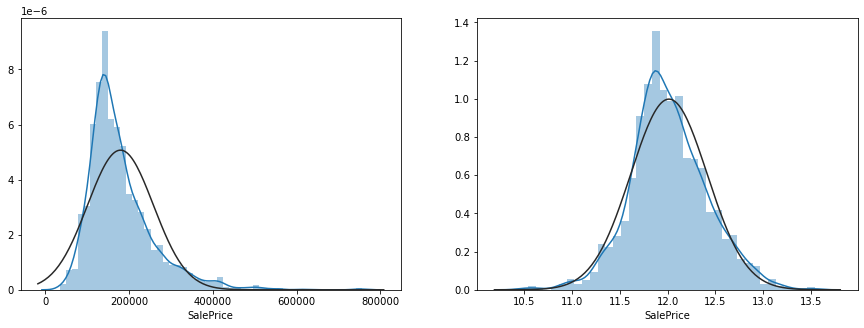

In [3]:
#로그를 통해 비대칭인 데이터를 해결해준다.(구글링)
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(15,5)
sns.distplot(train['SalePrice'], fit=norm, ax=ax1)
sns.distplot(np.log(train['SalePrice']+1), fit=norm, ax=ax2)

In [4]:
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>=0.3]
top_corr_features

Index(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'SalePrice'],
      dtype='object')

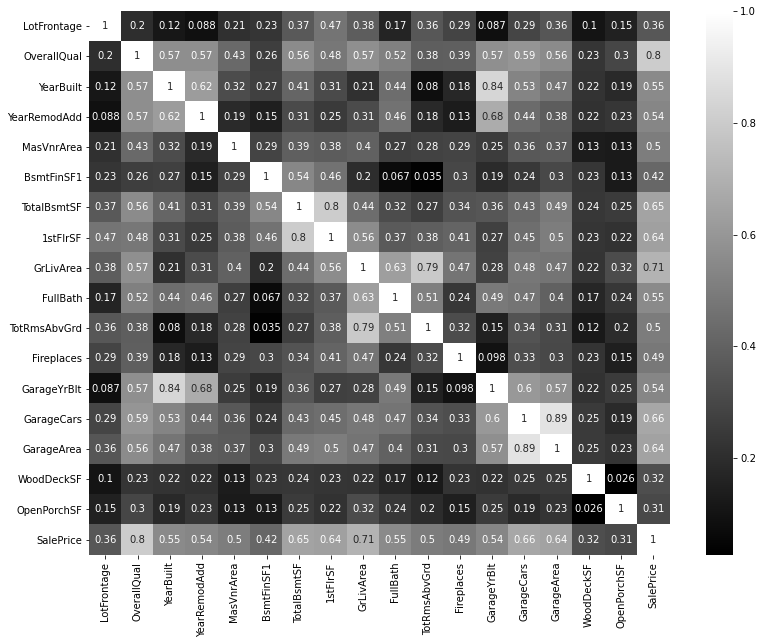

In [5]:
plt.figure(figsize=(13,10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="gray")

- OverallQual, GlivArea가 다른 변수보다 높은 상관관계

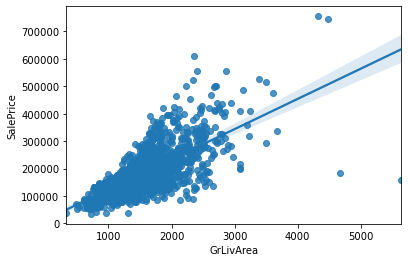

In [6]:
#이상치 확인(오른쪽)
sns.regplot(train['GrLivArea'], train['SalePrice'])

In [7]:
#이상치 제거 > 정확도를 높일 수 있음
train=train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

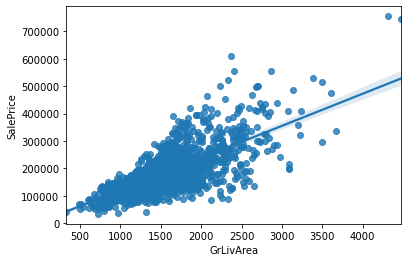

In [8]:
#재확인 > 오른쪽 아래 이상치 제거 확인
sns.regplot(train['GrLivArea'], train['SalePrice'])

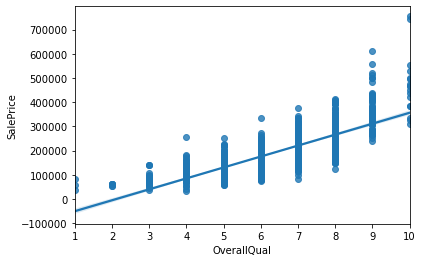

In [9]:
#OverallQual 커질수록 SalePrice 증가
sns.regplot(train['OverallQual'], train['SalePrice'])

In [10]:
n_train=pd.concat((test,submission['SalePrice']), axis=1)
n_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1752,20,RL,78.0,10206,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2009,WD,Normal,256215.060
1753,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,143055.170
1754,60,RL,NaN,9930,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,206454.020
1755,60,RL,92.0,9920,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,243815.690
1756,50,RL,66.0,21780,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,169228.480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,20,RL,70.0,8402,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,12,2007,New,Partial,117780.125
2916,50,RM,50.0,9140,Pave,NaN,Reg,HLS,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,4,2010,COD,Normal,116604.266
2917,20,RL,NaN,8050,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,GdPrv,NaN,0,5,2010,WD,Normal,136289.270


In [11]:
new_train=pd.concat((train,n_train))
new_train.shape

In [14]:
#train과 test를 합해서 두번 적용하는일이 없게 한다.
ta_train=new_train['SalePrice']
#같은 컬럼 사용해야함
new_train=new_train[list(test)]

tot_data=pd.concat((new_train,test), axis=0)
t_train=np.log(ta_train+1)

In [15]:
tot_data.shape

(4085, 79)

In [ ]:
ta_train=new_train['SalePrice']
new_train=new_train[list(test)]
tot_data=pd.concat((new_train,test), axis=0)
t_train=np.log(ta_train+1)

### 데이터 전처리(총 면적, 건축 연도, 화장실 갯수, 지하실 등등)
- 비슷한 컬럼명끼리 더해도 되지 않을까
- 등급으로 된 컬럼은 등급마다 점수를 매겨서 합해도 되지 않을까

In [16]:
cols=list(tot_data)
for col in list(tot_data):
    if (tot_data[col].isnull().sum())==0: #결측치 갯수 확인후 결측치가 아니라면 제거
        cols.remove(col)
    else:
        pass
    
#결측치인 컬럼들
print(cols)

['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


In [17]:
#시설이 없는 값을 none라는 문자열로 채운다
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
            'BsmtFinType2', 'MasVnrType', 'MSSubClass'):
    tot_data[col] = tot_data[col].fillna('None')

#시설이 없는 값을 0으로 채운다.
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 
            'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 
            'BsmtHalfBath', 'MasVnrArea','LotFrontage'):
    tot_data[col] = tot_data[col].fillna(0)
#최빈값 mode() 열    
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 
            'Exterior2nd', 'SaleType', 'Functional', 'Utilities'):
    tot_data[col] = tot_data[col].fillna(tot_data[col].mode()[0])
    
print("결측치 확인 : \n", tot_data.isnull().sum())

결측치 확인 : 
 MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 79, dtype: int64


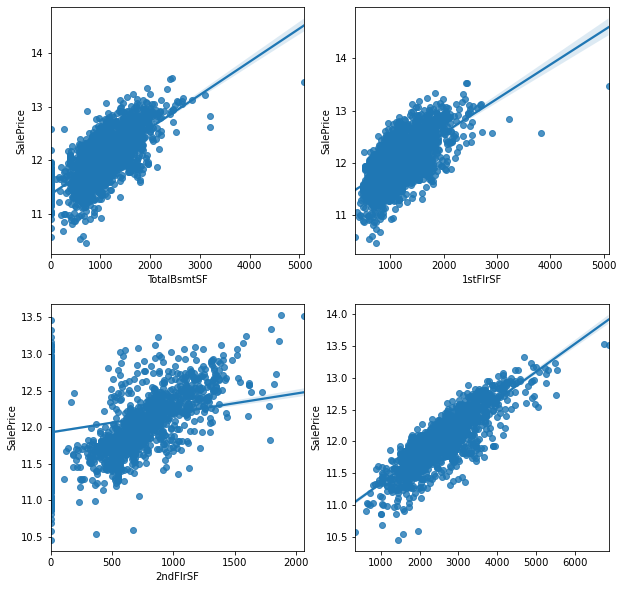

In [23]:
#'1stFlrSF, '2ndFlrSF', 'TotalBsmtSF'
#SalePrice 값은 t_train으로 따로 빼놨음
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(10,10)
sns.regplot(new_train['TotalBsmtSF'], t_train, ax=ax1)
sns.regplot(new_train['1stFlrSF'], t_train, ax=ax2)
sns.regplot(new_train['2ndFlrSF'], t_train, ax=ax3)
sns.regplot(new_train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF'], t_train, ax=ax4)

- 총면적과 가격이 상관관계가 크게 있어보인다.
- 새로운 변수를 만들어도 괜찮을 것 같다.

In [24]:
#tot_data['TotalSF']=tot_data['TotalBsmtSF'] + tot_data['1stFlrSF'] + tot_data['2ndFlrSF']
#2층과 지하실이 없는 집도 있을수 있다.
#tot_data['No2ndFlr']=(tot_data['2ndFlrSF']==0)
#tot_data['NoBsmt']=(tot_data['TotalBsmtSF']==0)

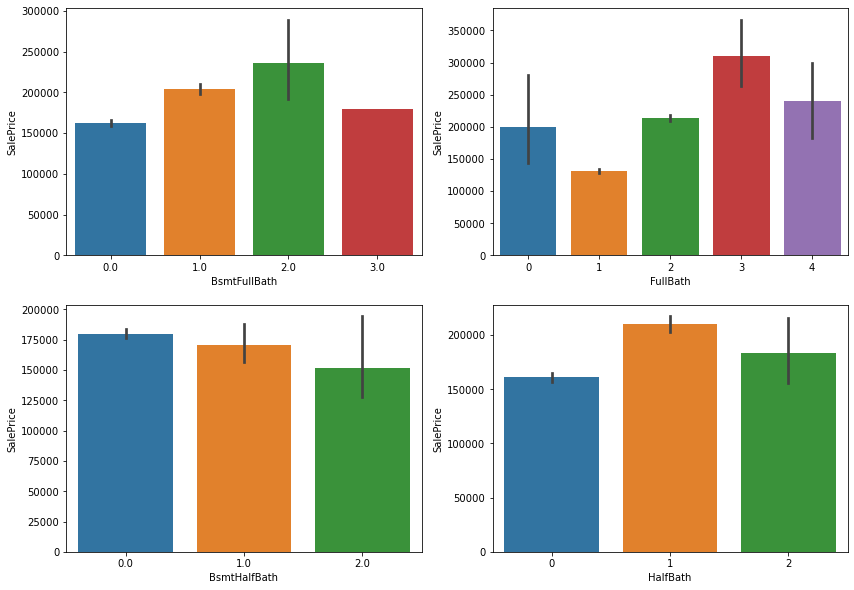

In [25]:
#화장실 전처리
#로그 씌어진 SalePrice로 값 비교 하기 힘들어서 원래 값을 y축으로 사용

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(14,10)
sns.barplot(train['BsmtFullBath'], ta_train, ax=ax1)
sns.barplot(train['FullBath'], ta_train, ax=ax2)
sns.barplot(train['BsmtHalfBath'], ta_train, ax=ax3)
sns.barplot(train['HalfBath'], ta_train, ax=ax4)

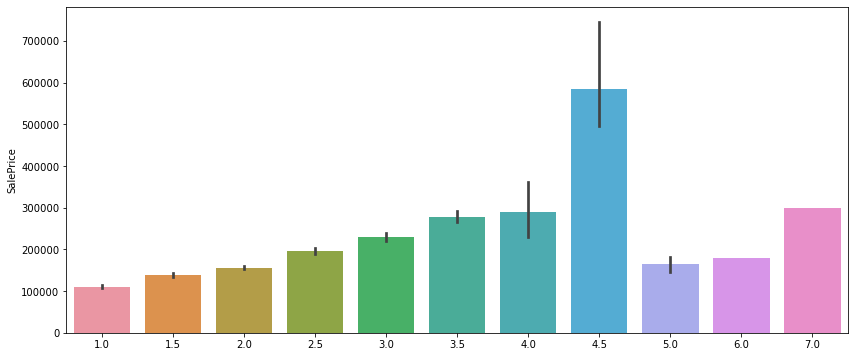

In [26]:
#면적처럼 화장실도 합해보자
#halfbath를 1/2화장실 이라고 한답니다. (교포들이)
figure, (ax5) = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(14,6)
sns.barplot(train['BsmtFullBath'] + train['FullBath'] + (train['BsmtHalfBath']/2) + 
            (train['HalfBath']/2), ta_train, ax=ax5)

- 화장실이 많을수록 집값이 비싸다.
- 5,6,7 은 어떻게 할까 고민해보자

In [27]:
tot_data['Bath']=tot_data['BsmtFullBath'] + tot_data['FullBath'] + (tot_data['BsmtHalfBath']/2) + (tot_data['HalfBath']/2)

In [42]:
new_train['Bath']=new_train['BsmtFullBath'] + new_train['FullBath'] + (new_train['BsmtHalfBath']/2) + (new_train['HalfBath']/2)

In [43]:
#5,6,7 을 비슷한 가격의 화장실 갯수로 바꿔주자
convert_title_dic={
    5.0 : 2.0,
    6.0 : 2.5,
    7.0 : 4.0,
    
    
    1.0 : 1.0,
    1.5 : 1.5,
    2.0 : 2.0,
    2.5 : 2.5,
    3.0 : 3.0,
    3.5 : 3.5,
    4.0 : 4.0,
    4.5 : 4.5
    
    
}

In [44]:
tot_data['Bath']=tot_data['Bath'].map(convert_title_dic)

In [45]:
new_train['Bath']=new_train['Bath'].map(convert_title_dic)

In [46]:
tot_data['Bath']

Id
1       3.0
2       2.5
3       3.0
4       2.5
5       2.5
       ... 
2915    1.0
2916    1.0
2917    2.0
2918    3.5
2919    1.0
Name: Bath, Length: 4085, dtype: float64

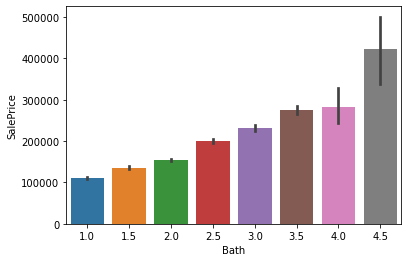

In [47]:
#다시 bath 컬럼 확인
sns.barplot(x='Bath', y=ta_train, data=new_train)

- 화장실 갯수와 가격간에 깔끔한 차트를 그릴 수 있었다.

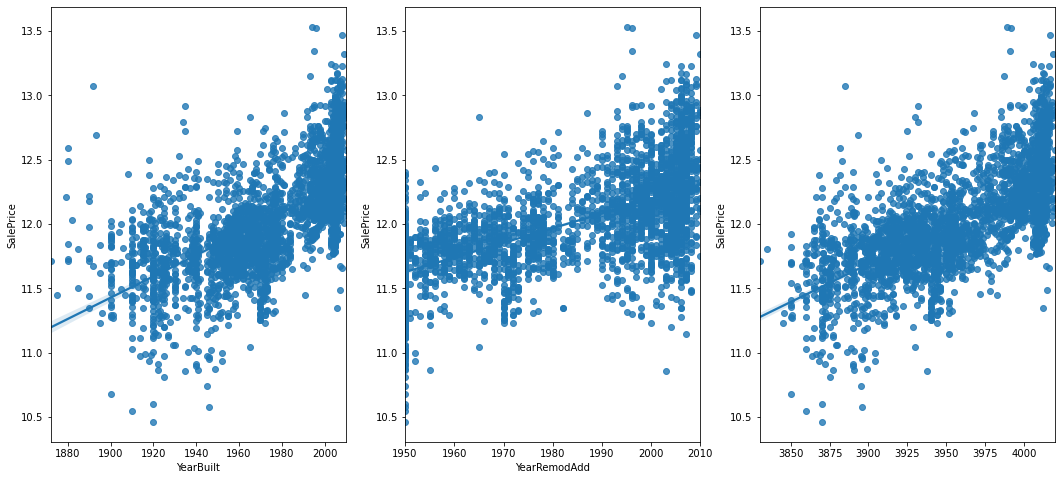

In [48]:
#건축연도와 리모델링 연도 시각화
#둘의 관계가 가격과 비슷해보이므로 합해도 되지 않을까
figure, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18,8)
sns.regplot(new_train['YearBuilt'], t_train, ax=ax1)
sns.regplot(new_train['YearRemodAdd'], t_train, ax=ax2)
sns.regplot((new_train['YearBuilt']+new_train['YearRemodAdd']), t_train, ax=ax3) 

-  신축에 리모델링까지 최근에 한 집은 가격이 비싼걸로 생각된다.

In [49]:
tot_data['PlusYeRe']=tot_data['YearBuilt']+tot_data['YearRemodAdd']

In [50]:
tot_data['MSSubClass']

Id
1       20
2       20
3       20
4       60
5       20
        ..
2915    20
2916    50
2917    20
2918    60
2919    20
Name: MSSubClass, Length: 4085, dtype: int64

In [51]:
#지하실 카테고리 숫자로 정리
convert_title_dic={
    'Ex' : 5,
    'Gd' : 4,
    'TA' : 3,
    'Fa' : 2,
    'Po' : 1,
    'NA' : 0,
    'Av' : 3,
    'Mn' : 2,
    'No' : 1,
    'GLQ' : 6,
    'ALQ' : 5,
    'BLQ' : 4,
    'Rec' : 3,
    'LwQ' : 2,
    'Unf' : 1,
    'None' : 0
    
}

In [52]:
#값 변환
tot_data['BsmtQual']=tot_data['BsmtQual'].map(convert_title_dic)
tot_data['BsmtCond']=tot_data['BsmtCond'].map(convert_title_dic)
tot_data['BsmtExposure']=tot_data['BsmtExposure'].map(convert_title_dic)
tot_data['BsmtFinType1']=tot_data['BsmtFinType1'].map(convert_title_dic)
tot_data['BsmtFinType2']=tot_data['BsmtFinType2'].map(convert_title_dic)

In [53]:
#Bsmt 끼리 값 합치기
tot_data['Bsmt']=tot_data['BsmtQual']+tot_data['BsmtCond']+tot_data['TotalBsmtSF']

In [54]:
tot_data['Bsmt']

Id
1        887.0
2        987.0
3       1501.0
4        576.0
5       1467.0
         ...  
2915    1127.0
2916     635.0
2917    1149.0
2918     930.0
2919     882.0
Name: Bsmt, Length: 4085, dtype: float64

In [55]:
#BsmtFin 끼리 값 합치기
tot_data['BsmtFin']=tot_data['BsmtFinType1']+tot_data['BsmtFinType2']+tot_data['BsmtFinSF1']
+tot_data['BsmtFinSF2']

In [56]:
tot_data['BsmtFin']

Id
1        815.0
2        324.0
3        929.0
4          2.0
5        574.0
         ...  
2915     212.0
2916     313.0
2917    1025.0
2918     877.0
2919     637.0
Name: BsmtFin, Length: 4085, dtype: float64

In [57]:
#차고 카테고리 숫자로 정리
convert_title_dic={
    'Ex' : 5,
    'Gd' : 4,
    'TA' : 3,
    'Fa' : 2,
    'Po' : 1,
    'NA' : 0,
    'Av' : 3,
    'Mn' : 2,
    'No' : 1,
    'GLQ' : 6,
    'ALQ' : 5,
    'BLQ' : 4,
    'Rec' : 3,
    'LwQ' : 2,
    'Unf' : 1,
    'None' : 0,
    'Fin' : 3,
    'RFn' : 2,
    'Unf' : 1,
    'BuiltIn' : 6,#내부에 있는게 제일 좋을 것 같음
    'Attchd' : 5,
    'Basment' : 4,
    '2Types' : 3,
    'Detchd' : 2,
    'CarPort' : 1
    
    
}

In [58]:
#값 넣기
tot_data['GarageType']=tot_data['GarageType'].map(convert_title_dic)
tot_data['GarageFinish']=tot_data['GarageFinish'].map(convert_title_dic)
tot_data['GarageQual']=tot_data['GarageQual'].map(convert_title_dic)
tot_data['GarageCond']=tot_data['GarageCond'].map(convert_title_dic)

In [59]:
#차고 컬럼 합치기
tot_data['GarageGd']=tot_data['GarageType']+tot_data['GarageFinish']+
tot_data['GarageQual']+tot_data['GarageCond']+tot_data['GarageArea']+tot_data['GarageCars']

In [60]:
tot_data['GarageGd'].isnull().sum()

0

In [61]:
#tot_data['SFGa']=tot_data['TotalSF']+tot_data['GarageGd']

In [62]:
#tot_data['SFGa']

## 상관관계가 높은 컬럼 2개를 곱해 가중치를 줄 수 있다.

In [63]:
tot_data['OvGr']=tot_data['OverallQual']*tot_data['GrLivArea']

In [64]:
tot_data['OvGr']

Id
1       10080
2        5886
3       10458
4       11858
5        8605
        ...  
2915     5600
2916     6642
2917     5715
2918    10284
2919     4940
Name: OvGr, Length: 4085, dtype: int64

In [44]:
#tot_data['OvLo']=tot_data['OverallQual']*tot_data['LotArea']

In [45]:
#tot_data['OvLo'].isnull().sum()

In [46]:
#tot_data['OvLo']

## 무의미한 변수들 삭제

In [65]:
tot_data.drop('Street', axis=1, inplace=True)
tot_data.drop('Utilities', axis=1, inplace=True)
tot_data.drop('Condition2', axis=1, inplace=True)
tot_data.drop('RoofMatl', axis=1, inplace=True)
tot_data.drop('Heating', axis=1, inplace=True)
tot_data.drop('PoolArea', axis=1, inplace=True)
tot_data.drop('PoolQC', axis=1, inplace=True)
tot_data.drop('MiscVal', axis=1, inplace=True)
tot_data.drop('MiscFeature', axis=1, inplace=True)
tot_data.drop('LowQualFinSF', axis=1, inplace=True)
tot_data.drop('OpenPorchSF', axis=1, inplace=True)
tot_data.drop('WoodDeckSF', axis=1, inplace=True)

In [66]:
numeric=tot_data.select_dtypes(np.number)

def log_transform(col_list):
    transformed_col=[]
    while len(col_list)!=0:
        col=col_list.pop(0)
        if tot_data[col].skew() > 0.5:
            tot_data[col]=np.log(tot_data[col]+1)
            transformed_col.append(col)
        else:
            pass
    print(f"{len(transformed_col)} features had been tranformed")
    print(tot_data.shape)

log_transform(list(numeric))

25 features had been tranformed
(4085, 73)


## 범주형 데이터 원 핫 인코딩

In [67]:
ob_feat = tot_data.dtypes[tot_data.dtypes == "object"].index
ob_feat

Index(['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'PavedDrive', 'Fence',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [68]:
one_hot_feature=pd.get_dummies(tot_data[['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'PavedDrive', 'Fence',
       'SaleType', 'SaleCondition']])

In [69]:
tot_data = pd.concat([tot_data,one_hot_feature],axis=1)

In [70]:
tot_data.drop(['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'PavedDrive', 'Fence',
       'SaleType', 'SaleCondition'],axis=1,inplace=True)

In [71]:
#train에서 'SalePrice 값 따로 분리했었음'
Xtrain=tot_data[:len(new_train)]
Xtest=tot_data[len(new_train):]
Xtrain.shape,Xtest.shape

((2917, 225), (1168, 225))

In [ ]:
model = xgb.XGBRegressor()
param_grid = {
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    'max_depth':[3,4,5,6,7,8,9,10],
    'n_estimators':[100,300, 500, 700, 800, 900],
    'colsample_bytree':[0.3,0.6,0.7,0.75,0.8,0.9],
    'colsample_bylevel':[0.3,0.6,0.7,0.75,0.8,0.9],
    'random_state' : [0]
}

grid = GridSearchCV(model, param_grid, cv=5, 
                           scoring="neg_root_mean_squared_error",
                           n_jobs=-1)

grid.fit(Xtrain, t_train)
print("최고 매개 : ", grid.best_params_)

In [54]:

model =xgb.XGBRegressor(colsample_bylevel= 0.3, 
                        colsample_bytree= 0.3, 
                        learning_rate = 0.1,
                        max_depth= 3, 
                        n_estimators= 800,
                       random_state=0)
model.fit(Xtrain, t_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.3,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=800, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [55]:
pre=model.predict(Xtest)

In [56]:
model = GradientBoostingRegressor(n_estimators=800, 
                                         learning_rate=0.1, 
                                         max_depth=3, 
                                         random_state=0)
model.fit(Xtrain, t_train)

GradientBoostingRegressor(n_estimators=800, random_state=0)

In [57]:
pre1=model.predict(Xtest)
pre1

array([12.45499826, 11.86027716, 12.25890034, ..., 11.84875185,
       12.10227675, 11.72869192])

In [58]:
model = make_pipeline(RobustScaler(), 
                      ElasticNet(alpha=0.00052, 
                                 l1_ratio=0.70654,
                                 random_state=0))
model.fit(Xtrain, t_train)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.00052, l1_ratio=0.70654, random_state=0))])

In [59]:
pre2=model.predict(Xtest)
pre2

array([12.36460528, 11.84825284, 12.2535309 , ..., 11.7656152 ,
       12.12348733, 11.67091497])

In [60]:
tot_pre=(pre+pre1+pre2)/3

In [61]:
submission['SalePrice']=np.exp(tot_pre)-1
submission['SalePrice']

Id
1752    249753.485358
1753    141118.225492
1754    208762.839378
1755    246220.080995
1756    169270.742881
            ...      
2915    122187.548593
2916    116985.788132
2917    134790.083576
2918    182185.626758
2919    120662.531495
Name: SalePrice, Length: 1168, dtype: float64

In [62]:
submission.to_csv('result.csv')